In [1]:
import numpy as np
import torch
import torch.nn as nn
import math
import fastai
from PIL import Image
from diffusers import DiffusionPipeline
from diffusers.utils import pt_to_pil
from dataloader import get_imagenette_dataloader
from quantize import quantize_img, plot_imgs
from ddpm import DDPMCB
from preprocessing import clip_preprocess, conditioning_transform
from functools import partial
from fastai.vision.all import (ImageDataLoaders, Resize, TensorImage, Learner, 
                               Callback, Normalize)
from encoder import ViTImageEncoder
import fastcore.all as fc

device = "cuda"

In [2]:
def method_helper(o): return list(filter(lambda x: x[0] != "_", dir(o)))

In [3]:
# stage g
stage_2 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0", text_encoder=None, variant="fp16", 
     torch_dtype=torch.float16, class_labels=None 
)
# stage_2.enable_model_cpu_offload()


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.
Keyword arguments {'class_labels': None} are not expected by IFSuperResolutionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
scheduler = stage_2.scheduler
unet = stage_2.unet.to(device)

In [5]:
dls = ImageDataLoaders.from_folder( "/mnt/wd/datasets/imagenette2", valid_pct=0.1, bs=1,)
one_batch = dls.one_batch()[0]
one_batch.shape

torch.Size([1, 3, 106, 278])

In [6]:
encoder = ViTImageEncoder(7, output_dim=unet.config.encoder_hid_dim).to(device)
encoder_preprocess = encoder.feature_extractor
c_preprocess = partial(clip_preprocess, stage_2=stage_2)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
img = c_preprocess(one_batch[0].cpu().numpy())

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [8]:
cond_transform = partial(conditioning_transform, encode_preprocess=None)
# cond_transform(img).shape

In [9]:
def preprocessing(x):
    if not isinstance(x, fastai.vision.core.TensorCategory):
        # x = TensorImage(x).permute(2,1,0).numpy()
        x = Resize(224)(x)
        x = TensorImage(x).permute(2,1,0)
    x = cond_transform(x)
    x = x.to("cpu")
    # x = c_preprocess(x)
    return x

# preprocessing(one_batch[0].cpu().numpy()).shape

In [10]:
# dls = ImageDataLoaders.from_folder(
#     "/mnt/wd/datasets/imagenette2",
#     valid_pct=0.1,
#     item_tfms=[preprocessing],
# #     batch_tfms=[Normalize()],
#     bs=3000,
#     num_workers=16
# )
# xb, _ = dls.one_batch()
# mean = xb.mean(dim=[0,2,3])  # Compute per-channel mean
# std = xb.std(dim=[0,2,3])    # Compute per-channel std
# print("Auto-calculated Mean:", mean)
# print("Auto-calculated Std:", std)

In [11]:
mean = torch.tensor([ 4.6301e-01,  4.5852e-01,  4.3105e-01,  1.8062e-03,  1.7940e-03,
                    1.6879e-03,  6.3991e-04, -1.0427e-05, -8.0591e-08,  3.9216e-03])
std = torch.tensor([0.2826, 0.2781, 0.3003, 0.0011, 0.0011, 0.0012, 0.0007, 0.0015, 0.0014, 0.0000])

In [12]:
dls = ImageDataLoaders.from_folder(
    "/mnt/wd/datasets/imagenette2",
    valid_pct=0.1,
    item_tfms=[preprocessing],
    # batch_tfms=[Normalize.from_stats(mean, std)],
    batch_tfms=[Normalize()],
    bs=4,
    num_workers=16
)

In [13]:
dls.one_batch()[0].shape
dls.one_batch()[0][0,2,...].std()

TensorImage(0.5810, device='cuda:0')

In [14]:
class CTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.unet = unet
        self.unet.class_embedding = None
        self.vit = ViTImageEncoder(7, output_dim=self.unet.config.encoder_hid_dim).to(device)

        for param in self.unet.parameters():
            param.requires_grad = False
        

    def forward(self, noisy_images, images, t):
        encoded = self.vit(images).expand(-1, 77, -1).half()

        return self.unet(noisy_images.half(), t.half(), encoded.half())[0]

In [15]:
model = CTModel()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
one_batch = dls.one_batch()
one_batch[0].shape
images = one_batch[0]
# images = torch.cat([images, images], dim=1)

In [17]:
# Without DDPM callback it won't work
# with torch.no_grad():
#     x = model(images, one_batch[0], torch.tensor([1.0]*4, dtype=torch.float16, device="cuda"))
# x

In [18]:
learn = Learner(dls, model, loss_func=torch.nn.MSELoss(), cbs=[DDPMCB(unet,scheduler)]).to_fp16()

In [19]:
from fastai.callback.hook import ActivationStats

# Create a list of layers to track. You can add or remove layers based on what you want to observe.
layers_to_track = [
    learn.model.vit.vit.embeddings.patch_embeddings.projection,
    learn.model.vit.vit.encoder.layer[0].attention.attention.query,
    learn.model.vit.vit.encoder.layer[0].attention.attention.key,
    learn.model.vit.vit.encoder.layer[0].attention.attention.value,
    learn.model.vit.vit.encoder.layer[0].intermediate.dense,
    learn.model.vit.vit.encoder.layer[0].output.dense,
    learn.model.vit.vit.encoder.layer[0].layernorm_before,
    learn.model.vit.vit.encoder.layer[0].layernorm_after,
    learn.model.vit.vit.encoder.layer[6].attention.attention.query,
    learn.model.vit.vit.encoder.layer[6].attention.attention.key,
    learn.model.vit.vit.encoder.layer[6].attention.attention.value,
    learn.model.vit.vit.encoder.layer[6].intermediate.dense,
    learn.model.vit.vit.encoder.layer[6].output.dense,
    learn.model.vit.vit.encoder.layer[6].layernorm_before,
    learn.model.vit.vit.encoder.layer[6].layernorm_after,
    learn.model.vit.vit.layernorm,
    learn.model.vit.vit.pooler.dense,
]

# Add the ActivationStats callback
astats = ActivationStats(modules=layers_to_track)
learn.add_cb(astats)

/home/artursil/anaconda3/envs/ai/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/artursil/anaconda3/envs/ai/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/home/artursil/anaconda3/envs/ai/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=devic

SuggestedLRs(valley=0.00019054606673307717)

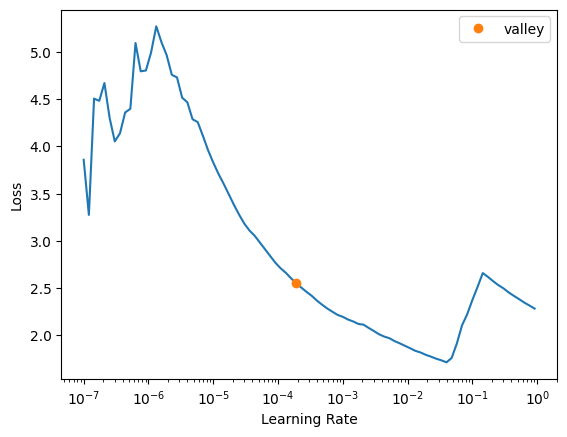

In [20]:
learn.lr_find()

In [21]:
lr = 10e-04
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,time
0,0.447057,0.452196,32:48


In [ ]:
learn.save("ctransfer_epoch_1.pth")
# learn = learn.load("ctransfer_epoch_1.pth")

In [22]:
# learn2 = learn.add_cb(astats)

In [23]:
# astats.color_dim()

In [25]:
lr = 10e-05
# learn.fit_one_cycle(1, lr)
learn.load("ctransfer_epoch_2.pth")

In [26]:
lr = 10e-05
# learn.save("ctransfer_epoch_2.pth")
learn.fit_one_cycle(4, lr)
learn.save("ctransfer_epoch_3_6.pth")
# learn.save("ctransfer_epoch_4.pth")
# learn.fit_one_cycle(1, lr)
# learn.save("ctransfer_epoch_5.pth")

epoch,train_loss,valid_loss,time
0,0.378776,0.372203,34:27
1,0.393772,0.484648,35:34


KeyboardInterrupt: 

In [26]:
learn.fit_one_cycle(3, lr)
learn.save("ctransfer_epoch_6_8.pth")

epoch,train_loss,valid_loss,time
0,1.137283,0.579024,33:06
1,0.487296,0.479819,33:00
2,0.440365,0.452983,32:42


epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [27]:
lr = 10e-06
learn.fit_one_cycle(1, lr)
learn.save("ctransfer_epoch_9.pth")

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 